## ALS11012_prsoxr_loader Tutorial

This tutorial will guide you toward importing your newly aquired p-RSoXR data using the ``ALS_PRSoXR_Loader``. The data can either be exported as a .csv file or the entire dataset can be compiled into an hdf5 file for a more complete meta-data friendly experience.

### Loading your data

The following packages are required for loading data

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
import sys

sys.path.append("../../DataReduction/")
from ALS11012_prsoxr_loader import *

The first step to reduce data with this tool is to create a python list that contains paths to each .fits file for a single theta-2theta scan. This will be for a single sample/polarization/energy.

In [11]:
path_s = pathlib.Path('../../../../MF114A/spol/250eV/')  
files = list(path_s.glob('*fits'))

In [13]:
files[:5] #Look at the first 5 files.

[WindowsPath('../../../../MF114A/spol/250eV/MFSeries_spol_67235-01744.fits'),
 WindowsPath('../../../../MF114A/spol/250eV/MFSeries_spol_67235-01745.fits'),
 WindowsPath('../../../../MF114A/spol/250eV/MFSeries_spol_67235-01746.fits'),
 WindowsPath('../../../../MF114A/spol/250eV/MFSeries_spol_67235-01747.fits'),
 WindowsPath('../../../../MF114A/spol/250eV/MFSeries_spol_67235-01748.fits')]

In this example, you can see that we use the following folder structure to sort our data.

    Sample directory:
        -Polarization 1 dir
            -Energy 1 dir
                - .fits...
            -Energy 2 dir
                -.fits...
            ...
        -Polarization 2 dir
            ...
Each folder contains a complete set of .fits file for the associated measurement.

We can now create an object that will load the entire dataset into memory. This will take a moment.

In [15]:
loader = ALS_PRSoXR_Loader(files, name='MF114A_spol_250eV')

To see the variables used in reducing the data, you can print the loader.

In [18]:
print(loader)

Sample Name - MF114A_spol_250eV
Number of scans - 402
______________________________
Reduction Variables
______________________________
Shutter offset = 0.00389278
Sample Location = 0
Angle Offset = 0.376
Energy Offset = 0
SNR Cutoff = 1.01
______________________________
Image Processing
______________________________
Image X axis = 200
Image Y axis = 200
Image Edge Trim = (5, 5)
Dark Calc Location = LHS
Dizinger Threshold = 10
Dizinger Size = 3


We can note a few things about this dataset:

    1) It contains 402 images that need to be reduced 
    2) The sample was mounted on the top of the sample plate (Sample Location = 0) 
    3) The Angle Offset is automatically determined to be 0.376
    4) The dark frame will be taken on the 'left hand side' of the image
All other parameteres can be set by the user depending on their prefered settings. See the API for a full list of variables and how they are used in the calculation.

Individual scans can be quickly viewed using the ``loader.check_spot()`` function.

Exposure: 0.00100000004749745
Beam Current: 0.0
Angle Theta: 0.0
T-2T: 0.0
CCD Theta: 0.0
Photon Energy: 249.996035379532
Polarization: 100.0
Higher Order Suppressor: 11.9986436398711
Horizontal Exit Slit Size: 100.0


Processed Variables:
Q: 0.0
Specular: 1000429
Background: 174035
Signal: 826394
SNR: 5.74843565949378
Beam center (84, 72)


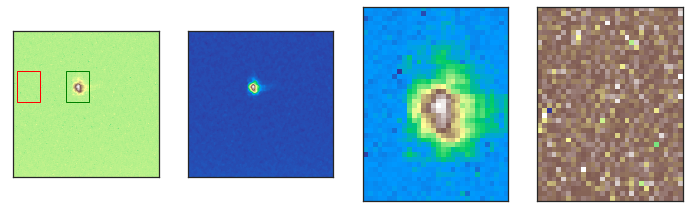

In [29]:
a = loader.check_spot(0, h=40, w=30)

This allows us to get a feel for the beamshape and data quality. The 4 displayed images are, in order from left to right:

    1) Raw CCD Image, no corrections
    2) CCD image passed through a median filter
    3) The beamspot determined by the maximum intensity pixel (black box in image 1)
    4) The dark frame that will be used (red box in image 1)

By adjusting the ROI (h, w) we can change the size of the beamspot until we have fully encorporated the beam shape, lets start with h=40 and w=30.

Call the loader with the chosen ROI to process the data.

In [32]:
refl = loader(h=40, w=30)

The output is a pandas dataframe, we can easily review the data by plotting it.

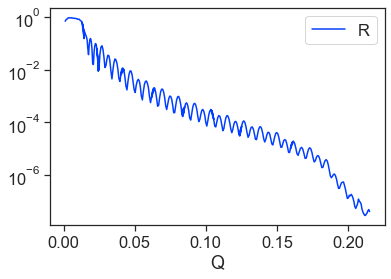

In [33]:
refl.plot(x='Q', y='R')
plt.yscale('log')

Oh no! Something odd is happening to our data at higher angles! This inflection around Q=0.17 is not a typical behavior of reflectivity, something may have gone wrong in the processing.

Lets review the higher angle datasets using our ``check_spot`` function.

Exposure: 1.0
Beam Current: 0.0
Angle Theta: 59.012
T-2T: 59.012
CCD Theta: 118.0235
Photon Energy: 250.001638213888
Polarization: 100.0
Higher Order Suppressor: 7.50014446251372
Horizontal Exit Slit Size: 1000.0


Processed Variables:
Q: 0.2172012852730185
Specular: 329467
Background: 328126
Signal: 1341
SNR: 1.0040868446877114
Beam center (15, 135)


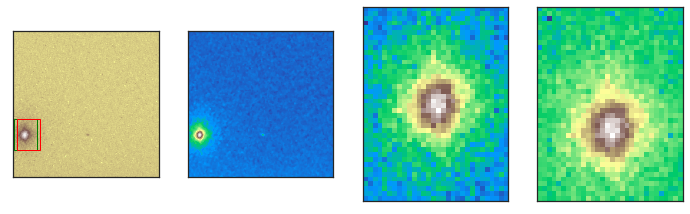

In [36]:
a = loader.check_spot(-5, h=40, w=30)

Ah! The sample must have been tilted slightly on the mount. The beamspot has drifted to the far side of the detector and is overlapping with the dark image. We can adjust the position that we take the dark subtraction by updating the ``self.dark_side`` parameter.

In [39]:
loader.darkside = 'RHS'

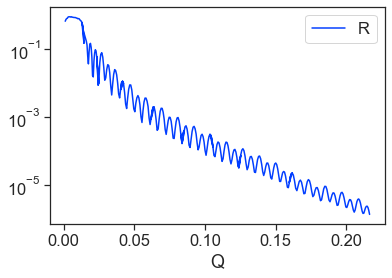

In [41]:
refl = loader(h=40, w=30)
refl.plot(x='Q', y='R')
plt.yscale('log')

Much better! The dataset looks good and is ready for 

The model can be viewed with the `structure.plot` function. The resulting depth profile will be a summary of the complex tensor components as a function of depth from the film surface. Setting `difference=True` provides a complimentary plot of the film birefringence: ($\delta_{xx} - \delta_{zz}$) and the dichroism: ($\beta_{xx} - \beta_{zz})$.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

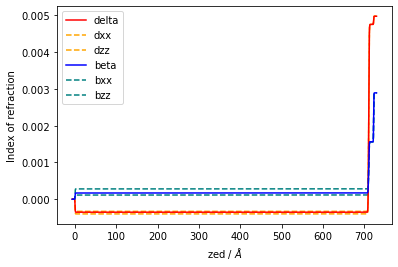

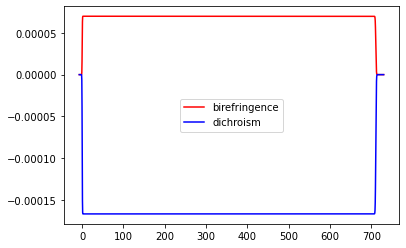

In [159]:
structure.plot(difference=True)

The *delta* and *beta* profiles correspond to the normalized trace of the dielectric tensor. This is equivalent to the components of an *isotropic* material
$$\delta = \frac{2\delta_{xx} + \delta_{zz}}{3}$$
$$\beta = \frac{2\beta_{xx} + \beta_{zz}}{3}$$

### Calculating polarized X-ray reflectivity

The assembled structure can be combined with an X-ray probe through the `PXR_ReflectModel` object.

In [160]:
model_spol = PXR_ReflectModel(structure, energy=en, pol='s', name=('spol'))
model_ppol = PXR_ReflectModel(structure, energy=en, pol='p', name=('ppol'))

`PXR_ReflectModel` requires two additional inputs to specify the incident X-rays. `pol` is used to specify the linear polarization state of the incident beam, and `en` is used to specify the photon energy. A combined model can be achieved by concatenating the outputs using either `pol='sp'` or `'pol='ps'` depending on the desired order.

A few Notes about `PXR_ReflectModel`:
 - Calculating a single polarization does not offer a performance increase, the 4x4 transfer matrix calculation provides both solutions simultaneously.
     - Instead, we will use `pol='sp'` to improve performance during Monte Carlo fitting, more on this later. 
 - Any energy specified for the given model will update any `PXR_MaterialSLD` objects during the calculation.
 
A quick plot of each polarization.

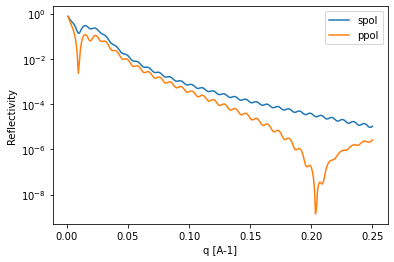

In [161]:
qvals = np.linspace(0.001, 0.25, 300)
plt.plot(qvals, model_spol(qvals), label='spol')
plt.plot(qvals, model_ppol(qvals), label='ppol')
plt.yscale('log')
plt.ylabel('Reflectivity')
plt.xlabel('q [A-1]')
plt.legend()

Success! The plot above gives the expected specular reflectivity of our input structure based on the incident polarization.

### Fitting data

All fitting utilizes the refnx package and requires the following imports.

In [162]:
from refnx.dataset import ReflectDataset #Object used to store data
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective #For fitting

We first want to load a set of example data that is provided in the GitHub directory.

For this example, the sample is a homogeneous slab of a glass-forming molecule vapor-deposited onto silicon. It is expected to be laying flat on the substrate.

In [163]:
sys.path.append("../../PyPXR/")
mypath_s = os.path.join(mypath, 'Feb19_Exp101_p100.txt')
mypath_p = os.path.join(mypath, 'Feb19_Exp101_p190.txt')

mydata_s = np.genfromtxt(mypath_s, delimiter='\t')
mydata_p = np.genfromtxt(mypath_p, delimiter='\t')

For an optimized calculation, we will concatenate the spol and ppol data into a single wave, allowing us to fit both polarizations simultaneously.

In [164]:
mydata = np.concatenate([mydata_s, mydata_p])
data = ReflectDataset(mydata.T) #Transpose to set the axis correctly

A model and data is combined to form an `Objective`.

In [165]:
model = PXR_ReflectModel(structure, energy=en, pol='sp') #Concatenated model
objective = Objective(model, data, transform=Transform('logY'))

Text(0.5, 0, 'q [A-1]')

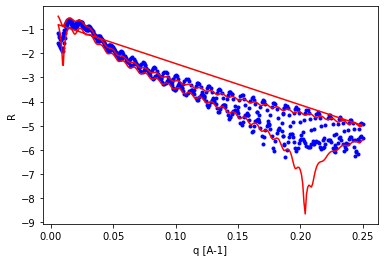

In [166]:
objective.plot()
plt.ylabel('R')
plt.xlabel('q [A-1]')

But wait! The data does not exhibit any indication of Brewsters angle at $\approx0.2A^-1$! This is an indication that there may be a complicated structure than our simple single layer model. Lets add an additional layer to the surface and remodel the data. 

In [167]:
#Make the new index of refraction
n2_xx = complex(-0.0004, 0.000627) # [unitless] #Ordinary Axis
n2_zz = complex(-0.0005, 0.000003) # [unitless] #Extraordinary Axis
material2 = PXR_SLD(np.array([n2_xx, n2_zz]), name='material2') #Molecule
material2_slab = material2(15,1)
#Reinitialize the model functions
structure = vacuum | material2_slab | material_slab | sio2_slab | si_slab
model = PXR_ReflectModel(structure, energy=en, pol='sp')
objective = Objective(model, data, transform=Transform('logY'))

Text(0.5, 0, 'q [A-1]')

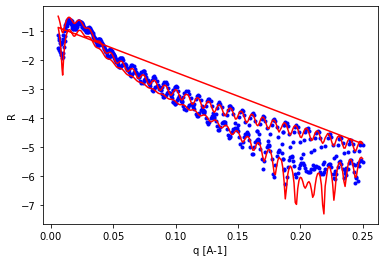

In [168]:
objective.plot()
plt.ylabel('R')
plt.xlabel('q [A-1]')

Now we want to refine our input model by fitting. We need to first setup the parametrs that we want to vary. This uses the `Parameter` object from refnx.

Each object that we have created has the following available parameters:

`PXR_Slab`
 - Thickness : ('thick')
 - Roughness : ('rough')
 
`PXR_MaterialSLD`
 - Density : ('density')
 
`PXR_Slab`
 - ordinary component of delta : ('xx and yy')
 - extraordinary component of delta : ('zz')
 - ordinary component of beta : ('ixx and iyy')
 - extraordinary component of beta : ('izz')
 - *Optional parameters:*
     - normalized trace of delta : ('diso')
     - normalized trace of beta : ('biso')
     - Birefringence : ('birefringence')
     - Dichroism : ('dichroism')

Optional parameters allow for alternative parameterizations through constraints. Only 'xx', 'yy', 'zz', 'ixx', 'iyy', and 'izz' are physically used in the calculation.

In [186]:
# Substrates
si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=False, bounds=(1,2))

sio2_slab.thick.setp(vary=True, bounds=(5,20))
sio2_slab.rough.setp(vary=True, bounds=(2,10))
sio2_slab.sld.density.setp(vary=False)

# The default tensor symmetry is for uniaxial materials.
# This automatically sets the constraint xx = yy and ixx = iyy
material_slab.thick.setp(vary=True, bounds=(400,900))
material_slab.rough.setp(vary=True, bounds=(0.2,20))
material_slab.sld.xx.setp(vary=True, bounds=(-0.00001, -0.01))
material_slab.sld.zz.setp(vary=True, bounds=(-0.00001, -0.01))
material_slab.sld.ixx.setp(vary=True, bounds=(0, 0.01))
material_slab.sld.izz.setp(vary=True, bounds=(0, 0.01))

material2_slab.thick.setp(vary=True, bounds=(5,30))
material2_slab.rough.setp(vary=True, bounds=(0.5,20))
material2_slab.sld.xx.setp(vary=True, bounds=(-0.00001, -0.001))
material2_slab.sld.zz.setp(vary=True, bounds=(-0.00001, -0.001))
material2_slab.sld.ixx.setp(vary=True, bounds=(0, 0.01))
material2_slab.sld.izz.setp(vary=True, bounds=(0, 0.01))


A full list of open parameters can be examined by looking at the `Objective.varying_parameters()`

In [172]:
print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'material2_thick', value=15          , bounds=[5.0, 30.0]>
<Parameter:'material2_xx' , value=-0.0004          , bounds=[-0.001, -0.0001]>
<Parameter:'material2_ixx', value=0.000627          , bounds=[0.0, 0.001]>
<Parameter:'material2_zz' , value=-0.0005          , bounds=[-0.001, -0.0001]>
<Parameter:'material2_izz', value=3e-06          , bounds=[0.0, 0.001]>
<Parameter:'material2_rough', value=1          , bounds=[0.5, 20.0]>
<Parameter:'material_thick', value=711          , bounds=[400.0, 900.0]>
<Parameter: 'material_xx' , value=-0.00033          , bounds=[-0.01, -0.0001]>
<Parameter:'material_ixx' , value=0.000113          , bounds=[0.0, 0.001]>
<Parameter: 'material_zz' , value=-0.0004          , bounds=[-0.01, -0.0001]>
<Parameter:'material_izz' , value=0.00028          , bounds=[0.0, 0.001]>
<Parameter:'material_rough', value=0.5          , bounds=[0.2, 20.0]

In order to initialize a fit, we construct a `CurveFitter` using an `Objective`

In [195]:
fitter = CurveFitter(objective)

Running a fit will envoke an `emcee` sampler object.

In this example:

    1) We begin by running 3000 sample in order to find the local minima.
    2) Once we have reached the minima, all samples outside of it are discarded. 
    3) Explore the minima by running a final 2000 samples.

In [176]:
fitter.sample(3000)
fitter.reset()
fitter.sample(2000)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [23:46<00:00,  2.80it/s]


[MCMCResult(name='material2_thick', param=Parameter(value=14.064230193127237, name='material2_thick', vary=True, bounds=Interval(lb=5.0, ub=30.0), constraint=None), stderr=0.029903199588606988, chain=array([[14.34117481, 14.41800952, 14.32237777, ..., 14.20627948,
         14.29260238, 14.19977161],
        [14.34117481, 14.41800952, 14.32237777, ..., 14.20810669,
         14.29260238, 14.19977161],
        [14.3496419 , 14.41800952, 14.32237777, ..., 14.20810669,
         14.29260238, 14.17589112],
        ...,
        [14.02851863, 14.05614855, 14.06237595, ..., 14.06002827,
         14.09065448, 14.04024229],
        [14.02851863, 14.05614855, 14.06237595, ..., 14.06002827,
         14.09199874, 14.04360472],
        [14.02851863, 14.05614855, 14.06237595, ..., 14.06349492,
         14.09199874, 14.04360472]]), median=14.064230193127237),
 MCMCResult(name='material2_xx', param=Parameter(value=-0.000999970197793277, name='material2_xx', vary=True, bounds=Interval(lb=-0.001, ub=-0.000

We can now check on our results by replotting the updated `Objective`

Text(0.5, 0, 'q [A-1]')

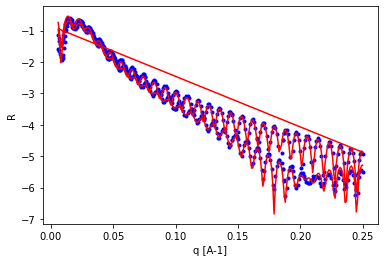

In [177]:
objective.plot()
plt.ylabel('R')
plt.xlabel('q [A-1]')

Looks great! What about the orientation depth profile?

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='zed / $\\AA$', ylabel='Index of refraction'>)


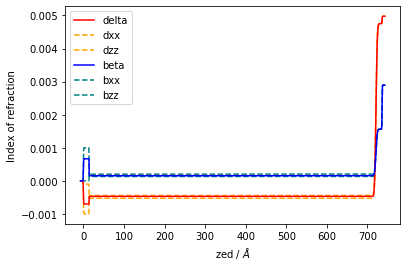

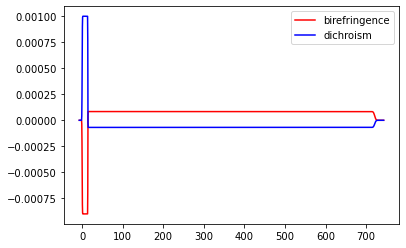

In [183]:
print(objective.model.structure.plot(difference=True))

So we found that our best fit model has a highly oriented surface layer and a more isotropic bulk. Fascinating...

We can now check on the final parameters

In [191]:
print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'material2_thick', value=14.0642 +/- 0.0299, bounds=[5.0, 30.0]>
<Parameter:'material2_xx' , value=-0.00099997 +/- 7.33e-08, bounds=[-0.001, -1e-05]>
<Parameter:'material2_ixx', value=0.00099997 +/- 7.33e-08, bounds=[0.0, 0.01]>
<Parameter:'material2_zz' , value=-0.00010003 +/- 9.35e-08, bounds=[-0.001, -1e-05]>
<Parameter:'material2_izz', value=2.6998e-08 +/- 7.83e-08, bounds=[0.0, 0.01]>
<Parameter:'material2_rough', value=0.501036 +/- 0.00313, bounds=[0.5, 20.0]>
<Parameter:'material_thick', value=706.984 +/- 0.0189, bounds=[400.0, 900.0]>
<Parameter: 'material_xx' , value=-0.000441856 +/- 9.59e-07, bounds=[-0.01, -1e-05]>
<Parameter:'material_ixx' , value=0.000131804 +/- 3.03e-07, bounds=[0.0, 0.01]>
<Parameter: 'material_zz' , value=-0.000525658 +/- 5.17e-07, bounds=[-0.01, -1e-05]>
<Parameter:'material_izz' , value=0.000200299 +/- 2.41e-07, bounds=[0.0, 0.01]>
<